# Integrate resources to create a drug repurposing hetnet

In [1]:
import pandas

import hetio.hetnet
import hetio.readwrite
import hetio.stats

from utils import rawgit, obo_iri

## Define the metagraph and instantiate the graph

In [2]:
kind_to_abbev = {
    
    # metanodes
    'compound': 'C',
    'disease': 'D',
    'gene': 'G',
    'anatomy': 'A',
    'symptom': 'S',
    'side effect': 'SE',
    'pathway': 'PW',
    'perturbation': 'PB',
    'biological process': 'BP',
    'cellular component': 'CC',
    'molecular function': 'MF',
    
    # metaedges
    'treats': 't',
    'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'covaries': 'c',
    'knockdown downregulates': 'kd',
    'knockdown upregulates': 'ku',
    'overexpression downregulates': 'od',
    'overexpression upregulates': 'ou',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [
    ('compound', 'disease', 'treats', 'both'),
    ('compound', 'disease', 'palliates', 'both'),
    ('compound', 'gene', 'binds', 'both'),
    ('compound', 'gene', 'upregulates', 'both'),
    ('compound', 'gene', 'downregulates', 'both'),
    ('compound', 'compound', 'resembles', 'both'),
    ('compound', 'side effect', 'causes', 'both'),
    ('anatomy', 'gene', 'expresses', 'both'),
    ('anatomy', 'gene', 'upregulates', 'both'),
    ('anatomy', 'gene', 'downregulates', 'both'),
    ('gene', 'gene', 'interacts', 'both'),
    ('gene', 'gene', 'covaries', 'both'),
    ('gene', 'gene', 'knockdown downregulates', 'forward'),
    ('gene', 'gene', 'knockdown upregulates', 'forward'),
    ('gene', 'gene', 'overexpression downregulates', 'forward'),
    ('gene', 'gene', 'overexpression upregulates', 'forward'),
    ('gene', 'pathway', 'participates', 'both'),
    ('perturbation', 'gene', 'regulates', 'both'),
    ('gene', 'biological process', 'participates', 'both'),
    ('gene', 'cellular component', 'participates', 'both'),
    ('gene', 'molecular function', 'participates', 'both'),
    ('disease', 'disease', 'resembles', 'both'),
    ('disease', 'gene', 'associates', 'both'),
    ('disease', 'gene', 'upregulates', 'both'),
    ('disease', 'gene', 'downregulates', 'both'),
    ('disease', 'anatomy', 'localizes', 'both'),
    ('disease', 'symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes

In [3]:
commit = 'a7362748a34211e5df6f2d185bb3246279760546'
url = rawgit('dhimmel', 'entrez-gene', commit, 'data/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [4]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'], 
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    graph.add_node(kind = 'gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [5]:
commit = '72614ade9f1cc5a5317b8f6836e1e464b31d5587'
url = rawgit('dhimmel', 'disease-ontology', commit, 'data/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,Hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,Brain cancer,DOcancerslim,neoplastic


In [6]:
for i, row in disease_df.iterrows():
    data = {'url': obo_iri(row.doid), 'license': 'CC-BY 3.0'}
    graph.add_node(kind='disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [7]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...


In [8]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {'inchikey': row.inchikey, 'inchi': row.inchi, 'url': url, 'license': 'CC-BY-NC 4.0'}
    graph.add_node(kind='compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [9]:
commit = '134f23479186abba03ba340fc6dc90e16c781920'
url = rawgit('dhimmel', 'uberon', commit, 'data/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [10]:
for i, row in uberon_df.iterrows():
    data = {'url': obo_iri(row['uberon_id']), 'license': 'CC-BY 3.0'}
    for xref in 'mesh_id', 'bto_id':
        if pandas.notnull(row[xref]):
            data[xref] = row[xref]
    graph.add_node(kind='anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [11]:
commit = 'a7036a37302973b15ab949aab4056d9bc062910e'
url = rawgit('dhimmel', 'mesh', commit, 'data/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0


In [12]:
for i, row in symptom_df.iterrows():
    url = 'http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&term={}'.format(row.mesh_id)
    data = {'url': url, 'license': 'CC0 1.0'}
    graph.add_node(kind='symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pathway Nodes and Edges

In [13]:
commit = '4916b525722f94f61d59ed38cb67aa3052404610'
url = rawgit('dhimmel', 'pathways', commit, 'data/pathways.tsv')
pathway_df = pandas.read_table(url)
pathway_df = pathway_df[pathway_df.n_coding_genes > 1]
pathway_df.tail(2)

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
1622,WP80_r68938,Nucleotide GPCRs,http://www.wikipathways.org/instance/WP80_r68938,12,12,wikipathways,CC-BY 3.0,10161|1241|134|135|136|140|2846|5028|5029|5030...,10161|1241|134|135|136|140|2846|5028|5029|5030...
1623,WP98_r72088,Prostaglandin Synthesis and Regulation,http://www.wikipathways.org/instance/WP98_r72088,30,30,wikipathways,CC-BY 3.0,1583|1906|1909|1910|301|302|306|307|308|309|32...,1583|1906|1909|1910|301|302|306|307|308|309|32...


In [14]:
for i, row in pathway_df.iterrows():
    pathway_id = row.identifier
    data = {'url': row.url, 'license': row.license}
    graph.add_node(kind='pathway', identifier=pathway_id, name=row['name'], data=data)
    
    for gene in row.coding_genes.split('|'):
        gene = int(gene)
        source_id = 'gene', gene
        target_id = 'pathway', pathway_id
        data = {'unbiased': False, 'url': row.url, 'license': row.license}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## Gene Ontology Domains

In [15]:
commit = '1e5caed07a65a230e533123f847fcc7fbc112e72'
url = rawgit('dhimmel', 'gene-ontology', commit, 'annotations/taxid_9606/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,24,142|291|1763|1890|3980|4205|4358|4976|5428|708...,PARP1|SLC25A4|DNA2|TYMP|LIG3|MEF2A|MPV17|OPA1|...
1,GO:0000003,reproduction,biological_process,9606,inferred,1272,18|49|51|90|91|92|100|109|113|116|117|133|150|...,ABAT|ACR|ACOX1|ACVR1|ACVR1B|ACVR2A|ADA|ADCY3|A...


In [16]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ')
    data = {'url': obo_iri(row.go_id), 'license': 'CC-BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'gene', gene
        data = {'unbiased': False, 'license': 'CC-BY 4.0'}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## Disease-gene associations from compilation

In [17]:
association_df = pandas.read_table('compile/DaG-association.tsv')
association_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,sources,license
0,DOID:2531,Hematologic cancer,25,ABL1,DISEASES|DisGeNET,NaN
1,DOID:2531,Hematologic cancer,27,ABL2,DisGeNET,ODbL 1.0


In [18]:
for i, row in association_df.iterrows():
    source_id = 'disease', row.doid_id
    target_id = 'gene', row.entrez_gene_id
    sources = sorted(row.sources.split('|'))
    data = {'sources': sources, 'unbiased': 'GWAS Catalog' in sources}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    graph.add_edge(source_id, target_id, 'associates', 'both', data)

## Disease-gene differential expression

In [19]:
commit = '498e140326981de646534fc5b5b039e111ccf257'
url = rawgit('dhimmel', 'stargeo', commit, 'data/diffex.tsv')
stargeo_df = pandas.read_table(url)
stargeo_df.head(2)

,slim_id,slim_name,direction,entrez_gene_id,gene_symbol
0,DOID:10652,Alzheimer's disease,down,65985,AACS
1,DOID:10652,Alzheimer's disease,down,79719,AAGAB


In [20]:
for i, row in stargeo_df.iterrows():
    source_id = 'disease', row.slim_id
    target_id = 'gene', row.entrez_gene_id
    kind = row.direction + 'regulates'
    data = {'unbiased': True, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, kind, 'both', data)

## Chemical similarity

In [21]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/similarity-slim.tsv.gz')
chemical_df = pandas.read_table(url, compression='gzip')
chemical_df = chemical_df[chemical_df.similarity >= 0.5]
chemical_df.head(2)

,compound0,compound1,similarity
1557,DB01489,DB00683,0.5362
1571,DB01489,DB01567,0.6260


In [22]:
for i, row in chemical_df.iterrows():
    source_id = 'compound', row.compound0
    target_id = 'compound', row.compound1
    data = {'similarity': row.similarity, 'unbiased': True, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Symptom edges

In [23]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,35.619601,22.459544,39.918352,0
1,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1593,76.580532,20.801631,41.885877,0


In [24]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'symptom', row.mesh_id
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'presents', 'both', data)

## Disease-localization edges

In [25]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,11209,1182.634069,9.477995,74.210761,0.000000e+00
1,DOID:10652,Alzheimer's disease,UBERON:0001890,forebrain,114,7.326350,15.560272,21.733764,5.971023e-99


In [26]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'anatomy', row.uberon_id
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'localizes', 'both', data)

## Disease-disease similarity

In [27]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2760,827.098152,3.336968,3.577398,0.000000e+00
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,332,96.723002,3.432482,3.593306,3.377672e-80


In [28]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'disease', row.doid_code_0
    target_id = 'disease', row.doid_code_1
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Anatomy-gene expression presence

In [29]:
expr_df = pandas.read_table('compile/GeT-expression.tsv.gz', low_memory=False)
expr_df = expr_df[expr_df.uberon_id.isin(uberon_df.uberon_id) & expr_df.entrez_gene_id.isin(coding_genes)]
expr_df.head(2)

,uberon_id,entrez_gene_id,sources,unbiased,license
218662,UBERON:0000002,2,Bgee,1,NaN
218663,UBERON:0000002,9,Bgee,1,NaN


In [30]:
for i, row in expr_df.iterrows():
    source_id = 'gene', row['entrez_gene_id']
    target_id = 'anatomy', row['uberon_id']
    data = {'unbiased': bool(row['unbiased'])}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    graph.add_edge(source_id, target_id, 'expresses', 'both', data)

## Anatomy-gene differential expression

In [31]:
commit = '4ceb60f91cd942199ea5453bb14f6b76df4dc158'
url = rawgit('dhimmel', 'bgee', commit, 'data/diffex.tsv.gz')
diffex_df = pandas.read_table(url, compression='gzip')
diffex_df = pandas.melt(diffex_df, id_vars='GeneID', var_name='uberon_id', value_name='direction')
diffex_df = diffex_df.query("direction != 0")
diffex_df = diffex_df[diffex_df.uberon_id.isin(uberon_df.uberon_id) & diffex_df.GeneID.isin(coding_genes)]
diffex_df = diffex_df.replace({'direction': {-1: 'downregulates', 1: 'upregulates'}})
diffex_df.head(2)

,GeneID,uberon_id,direction
37241,2,UBERON:0000002,upregulates
37249,18,UBERON:0000002,downregulates


In [32]:
for i, row in diffex_df.iterrows():
    source_id = 'gene', row['GeneID']
    target_id = 'anatomy', row['uberon_id']
    data = {'unbiased': True}
    graph.add_edge(source_id, target_id, row['direction'], 'both', data)

## Compound bindings

In [33]:
binding_df = pandas.read_table('compile/CbG-binding.tsv')
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license
0,DB00014,2798,DrugBank (target),20053189,agonist,NaN,NaN
1,DB00014,3973,DrugBank (target),17016423|17139284|20053189,agonist,NaN,NaN


In [34]:
for i, row in binding_df.iterrows():
    source_id = 'compound', row.drugbank_id
    target_id = 'gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Protein Interactions

In [35]:
commit = 'f6a7edbc8de6ba2d7fe1ef3fee4d89e5b8d0b900'
url = rawgit('dhimmel', 'ppi', commit, 'data/ppi-hetio-ind.tsv')
ppi_df = pandas.read_table(url)
ppi_df = ppi_df[ppi_df.gene_0.isin(coding_genes) & ppi_df.gene_1.isin(coding_genes)]
ppi_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,hetio-dag,0
1,1,1026,hetio-dag,0


In [36]:
for i, row in ppi_df.iterrows():
    source_id = 'gene', row.gene_0
    target_id = 'gene', row.gene_1
    data = {
        'sources': row.sources.split('|'),
        'unbiased': bool(row.unbiased),
    }
    graph.add_edge(source_id, target_id, 'interacts', 'both', data)

## Evolutionary rate covariation

In [37]:
commit = '757733f77a89499439c887acb88456e011c5322e'
url = rawgit('dhimmel', 'erc', commit, 'data/erc_mam33-entrez-gt-0.6.tsv.gz')
erc_df = pandas.read_table(url, compression='gzip')
erc_df = erc_df[erc_df.correlation >= 0.75]
erc_df = erc_df[erc_df.source_entrez.isin(coding_genes) & erc_df.target_entrez.isin(coding_genes)]
erc_df.head(2)

,source_entrez,target_entrez,correlation,n_ucsc_genes
29,9,3295,0.77623,1
46,9,23313,0.79472,1


In [38]:
for i, row in erc_df.iterrows():
    source_id = 'gene', row.source_entrez
    target_id = 'gene', row.target_entrez
    data = {'unbiased': True}
    graph.add_edge(source_id, target_id, 'covaries', 'both', data)

## MSigDB -- Perturbations

In [39]:
commit = '019dc51bf24d79c035741b01b0641c52c10cfabc'
url = rawgit('dhimmel', 'msigdb', commit, 'data/msigdb.tsv')
msigdb_df = pandas.read_table(url)
msigdb_df.head(2)

,collection,gene_set,url,genes
0,c1.all,chr10p11,http://www.broadinstitute.org/gsea/msigdb/card...,58|1326|3688|3799|6840|6935|7581|7587|8325|845...
1,c1.all,chr10p12,http://www.broadinstitute.org/gsea/msigdb/card...,783|1390|4360|8028|8029|8559|8829|9317|10529|2...


In [40]:
for i, row in msigdb_df[msigdb_df.collection == 'c2.cgp'].iterrows():
    graph.add_node('perturbation', row.gene_set, data={'url': row.url})
    genes = [int(gene) for gene in row.genes.split('|')]
    target_id = 'perturbation', row.gene_set
    for gene in genes:
        source_id = 'gene', gene
        data = {'unbiased': False}
        graph.add_edge(source_id, target_id, 'regulates', 'both', data)

## Indications

In [41]:
commit = 'd3d57b07abcf8d7af55f8e42ef7c4c99acd87ca8'
url = rawgit('dhimmel', 'indications', commit, 'curation/pk/curation-PK.tsv')
indication_df = pandas.read_table(url)
indication_df['drugbank_id'] = indication_df.drug_url.map(lambda x: x.rsplit('/', 1)[-1])
indication_df['doid_id'] = indication_df.disease_url.map(lambda x: x.rsplit('/', 1)[-1].replace('%3A', ':'))
# Use PK's calls, excluding lone calls.
indication_df = indication_df[indication_df['pouya agreed with at least one person']]
dm_df = indication_df.query("PK == 'DM'").copy()
dm_df['kind'] = 'treats'
sym_df = indication_df.query("PK == 'SYM'").copy()
sym_df['kind'] = 'palliates'
indication_df = pandas.concat([dm_df, sym_df])
indication_df.head(2)

,drug,disease,CSH,AJG,PK,CSH_notes,AJG_notes,PK_notes,google,uptodate,drug_url,disease_url,tie,3-person consensus,pouya agreed with at least one person,drugbank_id,doid_id,kind
0,Acarbose,type 2 diabetes mellitus,DM,SYM,DM,(glucosidase inhibitor),NaN,NaN,https://www.google.com/webhp#q=Acarbose,http://www.uptodate.com/contents/search?search...,http://www.drugbank.ca/drugs/DB00284,http://www.disease-ontology.org/term/DOID%3A9352,True,False,True,DB00284,DOID:9352,treats
1,Acebutolol,hypertension,DM,SYM,DM,(cardioselective beta blocker,NaN,NaN,https://www.google.com/webhp#q=Acebutolol,http://www.uptodate.com/contents/search?search...,http://www.drugbank.ca/drugs/DB01193,http://www.disease-ontology.org/term/DOID%3A10763,True,False,True,DB01193,DOID:10763,treats


In [42]:
for i, row in indication_df.iterrows():
    source_id = 'disease', row.doid_id
    target_id = 'compound', row.drugbank_id
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, row['kind'], 'both', data)

## LINCS compound-gene expression

In [43]:
commit = 'ff88e02ba45d62a5e7874c05c3ef019d06e235ed'

In [44]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/binary/consensi-drugbank-binary.tsv')
l1000_df = pandas.read_table(url)
l1000_df = l1000_df[l1000_df.perturbagen.isin(compound_df.drugbank_id)]
l1000_df.head(2)

,perturbagen,entrez_gene_id,z_score,direction
0,DB00014,6676,4.844,up
1,DB00091,332,-17.985,down


In [45]:
mapper = {'up': 'upregulates', 'down': 'downregulates'}
for i, row in l1000_df.iterrows():
    source_id = 'compound', row.perturbagen
    target_id = 'gene', row.entrez_gene_id
    data = {'z_score': row.z_score, 'unbiased': True}
    kind = mapper[row.direction]
    graph.add_edge(source_id, target_id, kind, 'both', data)

## LINCS genetic perturbations

In [46]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/binary/consensi-knockdown-binary.tsv')
l1000_kd_df = pandas.pandas.read_table(url)

url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/binary/consensi-overexpression-binary.tsv')
l1000_oe_df = pandas.pandas.read_table(url)

mapper = {'up': 'knockdown upregulates', 'down': 'knockdown downregulates'}
l1000_kd_df['kind'] = l1000_kd_df.direction.map(lambda x: mapper[x])

mapper = {'up': 'overexpression upregulates', 'down': 'overexpression downregulates'}
l1000_oe_df['kind'] = l1000_oe_df.direction.map(lambda x: mapper[x])

l1000_genetic_df = pandas.concat([l1000_kd_df, l1000_oe_df])
l1000_genetic_df = l1000_genetic_df[l1000_genetic_df.perturbagen.isin(coding_genes)]

l1000_genetic_df.head(2)

,perturbagen,entrez_gene_id,z_score,direction,kind
0,2,27032,-7.437,down,knockdown downregulates
1,2,2886,-7.407,down,knockdown downregulates


In [47]:
for i, row in l1000_genetic_df.iterrows():
    source_id = 'gene', row.perturbagen
    target_id = 'gene', row.entrez_gene_id
    if source_id == target_id:
        continue
    data = {'z_score': row.z_score, 'unbiased': True}
    graph.add_edge(source_id, target_id, row.kind, 'forward', data)

## Side Effects - SIDER

In [48]:
commit = 'be3adebc0d845baaddb907a880890cb5e85f5801'
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effect-terms.tsv')
side_effect_df = pandas.read_table(url)
side_effect_df.head(2)

,umls_cui_from_meddra,side_effect_name
0,C0863129,AGEP
1,C0001849,AIDS dementia complex


In [49]:
for i, row in side_effect_df.iterrows():
    umls_id = row['umls_cui_from_meddra']
    data = {'url': 'http://sideeffects.embl.de/se/{}/'.format(umls_id), 'license': 'CC-BY-NC-SA 4.0'}
    graph.add_node(kind='side effect', identifier=umls_id, name=row['side_effect_name'])

In [50]:
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effects.tsv')
sider_df = pandas.read_table(url)
sider_df = sider_df[sider_df.drugbank_id.isin(compound_df.drugbank_id)]
sider_df.head(2)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
6398,DB01048,Abacavir,C0001849,AIDS dementia complex
6399,DB01048,Abacavir,C0232487,Abdominal discomfort


In [51]:
for i, row in sider_df.iterrows():
    source_id = 'compound', row.drugbank_id
    target_id = 'side effect', row.umls_cui_from_meddra
    data = {'unbiased': False, 'license': 'CC-BY-NC-SA 4.0'}
    graph.add_edge(source_id, target_id, 'causes', 'both', data)

## Network visualizations and stats

In [52]:
# Create and save degree distribution vizualizations
hetio.stats.plot_degrees(graph, 'viz/degrees.pdf')

In [53]:
import importlib
importlib.reload(hetio.stats)

<module 'hetio.stats' from '/home/dhimmels/Documents/github/hetio/hetio/stats.py'>

In [54]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv('data/summary/metanodes.tsv', sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
6,anatomy,A,4,402,2
5,biological process,BP,1,11157,0
8,cellular component,CC,1,1368,0
9,compound,C,7,1552,18
3,disease,D,8,137,1
2,gene,G,20,20945,1595
0,molecular function,MF,1,2865,0
7,pathway,PW,1,1620,0
4,perturbation,PB,1,3396,0
1,side effect,SE,1,5734,33


In [55]:
# Total number of nodes
metanode_df.nodes.sum()

49614

In [56]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv('data/summary/metaedges.tsv', sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,anatomy - downregulates - gene,AdG,102240,36,15097,102240
1,anatomy - expresses - gene,AeG,1006278,256,18147,974497
2,anatomy - upregulates - gene,AuG,97848,36,15929,97848
3,compound - binds - gene,CbG,10747,1377,1586,0
4,compound - causes - side effect,CcSE,138944,1071,5701,0
5,compound - downregulates - gene,CdG,19936,742,920,19936
6,compound - palliates - disease,CpD,366,204,50,0
7,compound - resembles - compound,CrC,6486,1042,1054,6486
8,compound - treats - disease,CtD,639,337,75,0
9,compound - upregulates - gene,CuG,16989,726,952,16989


In [57]:
# Number of edges in the network
metaedge_df.edges.sum()

3107960

## Save graph

In [58]:
# Write nodes to a table
path = 'data/nodes.tsv'
hetio.readwrite.write_nodetable(graph, path)

# Write edges to a table
path = 'data/edges.sif.gz'
hetio.readwrite.write_sif(graph, path)

In [59]:
# Write a subset of edges to a table
path = 'data/edges-10.sif'
hetio.readwrite.write_sif(graph, path, max_edges=10)

path = 'data/edges-5k.sif.gz'
hetio.readwrite.write_sif(graph, path, max_edges=5000)

In [60]:
# Write metagraph as json
path = 'data/metagraph.json'
hetio.readwrite.write_metagraph(metagraph, path)

In [61]:
# Write graph as json
path = 'data/hetnet.json.gz'
hetio.readwrite.write_graph(graph, path)

In [62]:
! sha256sum data/hetnet.json.gz

528a0a68a8f52703573b72a71177286f07dde66bdafbc7d67d451c3faff3a60d  data/hetnet.json.gz


## Barplots of metaedge and metanode counts

In [63]:
import seaborn
%matplotlib inline

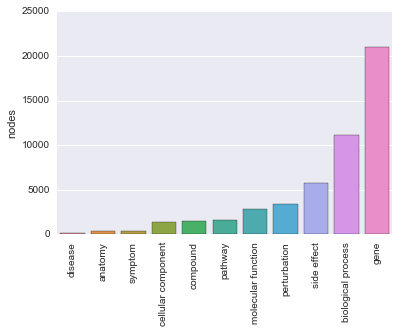

In [64]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

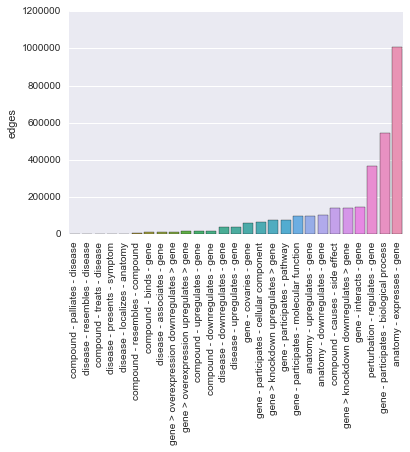

In [65]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');